loaded cifar100 vit_tiny_patch16_224 L1 50
loaded cifar100 vit_tiny_patch16_224 L1 200
loaded cifar100 vit_tiny_patch16_224 L1 500
loaded cifar100 vit_tiny_patch16_224 L1 1000
loaded cifar100 vit_tiny_patch16_224 L1 2000
loaded cifar100 vit_tiny_patch16_224 L1 5000
loaded cifar100 vit_tiny_patch16_224 L1 10000
loaded cifar100 vit_tiny_patch16_224 L1 20000
loaded cifar100 vit_tiny_patch16_224 L1 60000
loaded cifar100 vit_tiny_patch16_224 L1 120000
loaded cifar100 vit_tiny_patch16_224 L1 300000
loaded cifar100 vit_tiny_patch16_224 spatial 40
loaded cifar100 vit_tiny_patch16_224 spatial 140
loaded cifar100 vit_tiny_patch16_224 spatial 325
loaded cifar100 vit_tiny_patch16_224 spatial 650
loaded cifar100 vit_tiny_patch16_224 spatial 2600
loaded cifar100 vit_tiny_patch16_224 spatial 8000
loaded cifar100 vit_tiny_patch16_224 spatial 16000
loaded cifar100 vit_tiny_patch16_224 spatial 32000
loaded cifar100 vit_tiny_patch16_224 spatial 64000
loaded cifar100 vit_tiny_patch16_224 spatial-swap 40
l

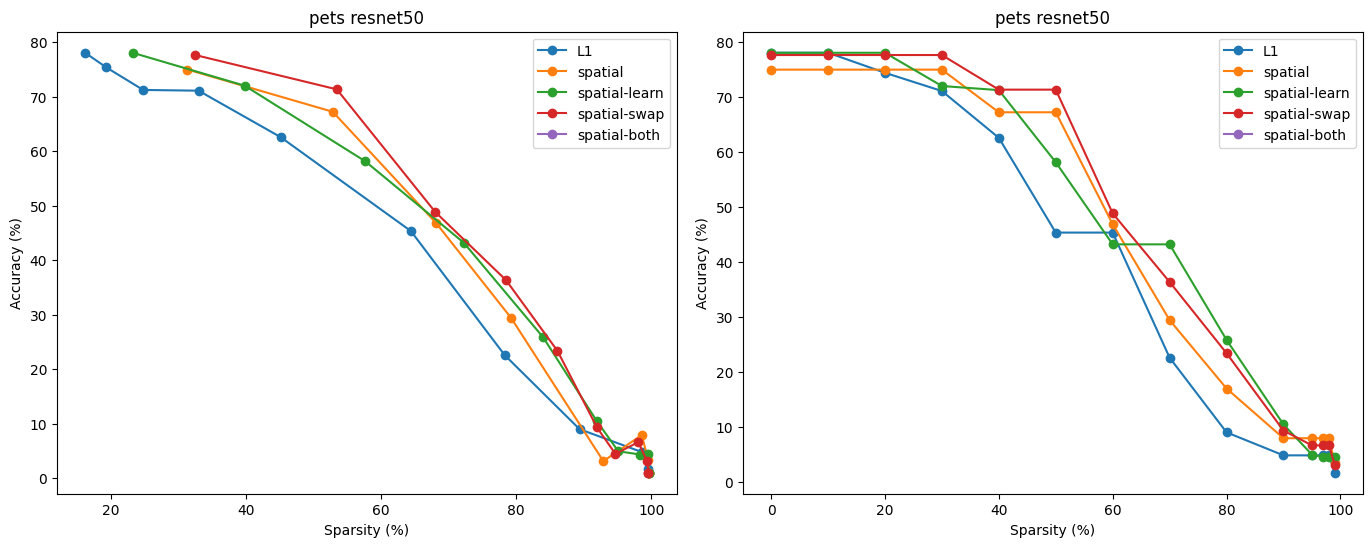

In [33]:
import util
import glob
import timm
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pickle
import os
from collections import defaultdict

datasets = ["cifar100"]
models = ["vit_tiny_patch16_224"]
modes = {
    "L1" : [50, 200, 500, 1000, 2000, 5000, 10000, 20000, 60000, 120000, 300000],
    "spatial": [40,140, 325, 650, 1300, 2600, 4000, 8000, 16000, 32000, 64000],
    "spatial-swap": [40,140, 325, 650, 1300, 2600, 4000, 8000, 16000, 32000, 64000],
    "spatial-learn": [40,140, 325, 650, 1300, 2600, 4000, 8000, 16000, 32000, 64000],
    "spatial-both": [40,140, 325, 650, 1300, 2600, 4000, 8000, 16000, 32000, 64000],
}

results = defaultdict(lambda:  defaultdict(lambda:  defaultdict(lambda: {})))
for dataset in datasets:
    for model in models:
        for mode, gammas in modes.items():
            for gamma in gammas:
                path = dataset +"/" + mode + "/" 
                file_name = mode + ":" +model+":"+str(gamma) 
                name = "./metrics/"+path+ file_name +'.pkl'
                if os.path.exists(name):
                    with open(name, 'rb') as f:
                        result = pickle.load(f)
                    results[dataset][model][mode][gamma]=result
                    print("loaded",dataset,model,mode,gamma)


y_axis = "final_acc"
x_axis = "percent_below_t"#"percent_dead_neurons" # "modularity" # "percent_below_t"
ylabel = "Accuracy (%)"
xlabel = "Sparsity (%)"
threshold = "0.001"
dataset="cifar100"
model="vit_tiny_patch16_224"
modes = ["L1","spatial","spatial-learn","spatial-swap","spatial-both"]
title = "pets resnet50"

lists=[]
labels=[]
for mode in modes:
    metrics=[]
    for gamma in results[dataset][model][mode].keys():
        metrics.append((float((results[dataset][model][mode][gamma][threshold][y_axis])), float(results[dataset][model][mode][gamma][threshold][x_axis])))
    lists.append(metrics)
    labels.append(mode)
image1 = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)





lists=[]
labels=[]
for mode in modes:
    temp = []
    max_tuples=[]
    for p in [100,90,80,70,60,50,40,30,20,10,5,3,2,1]:
        gammas =  [x for x in results[dataset][model][mode].keys()]
        temp = [(results[dataset][model][mode][gamma][str(p)][y_axis],100-p) for gamma in gammas]
        if len(temp)==0:
            continue
        max_tuple = max(temp, key=lambda x: x[0])
        max_tuples.append(max_tuple)
    lists.append(max_tuples)
    labels.append(mode)

image2 = util.plot_lists(lists, title=title, xlabel=xlabel, ylabel=ylabel, labels=labels)

util.make_image_grid([[image1,image2]])